# Analyze Order Book Data

## Imports & Settings

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
from collections import Counter
from time import time
from datetime import datetime, timedelta, time
import seaborn as sns
import matplotlib as mpl
from pylab import rcParams 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import pi
from bokeh.plotting import figure, show, output_file, output_notebook
from scipy.stats import normaltest
import statsmodels.api as sm

In [4]:
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#plt.style.use('fivethirtyeight')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 12, 6

In [5]:
data_path = Path('data')
itch_store = str(data_path / 'itch.h5')
order_book_store = str(data_path / 'order_book.h5')
stock = 'AAPL'
date = '20190327'
title = '{} | {}'.format(stock, pd.to_datetime(date).date())

## Load system event data

In [6]:
with pd.HDFStore(itch_store) as store:
    sys_events = store['S'].set_index('event_code').drop_duplicates()
    sys_events.timestamp = sys_events.timestamp.add(pd.to_datetime(date)).dt.time
    market_open = sys_events.loc['Q', 'timestamp']
    market_close = sys_events.loc['M', 'timestamp']

## Trade Summary

We will combine the messages that refer to actual trades to learn about the volumes for each asset.

In [7]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R']
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8712 entries, 0 to 8711
Data columns (total 17 columns):
stock_locate                      8712 non-null int64
tracking_number                   8712 non-null int64
timestamp                         8712 non-null timedelta64[ns]
stock                             8712 non-null object
market_category                   8712 non-null object
financial_status_indicator        8712 non-null object
round_lot_size                    8712 non-null int64
round_lots_only                   8712 non-null object
issue_classification              8712 non-null object
issue_sub_type                    8712 non-null object
authenticity                      8712 non-null object
short_sale_threshold_indicator    8712 non-null object
ipo_flag                          8712 non-null object
luld_reference_price_tier         8712 non-null object
etp_flag                          8712 non-null object
etp_leverage_factor               8712 non-null int64
inverse_

As expected, a small number of the over 8,500 equity securities traded on this day account for most trades

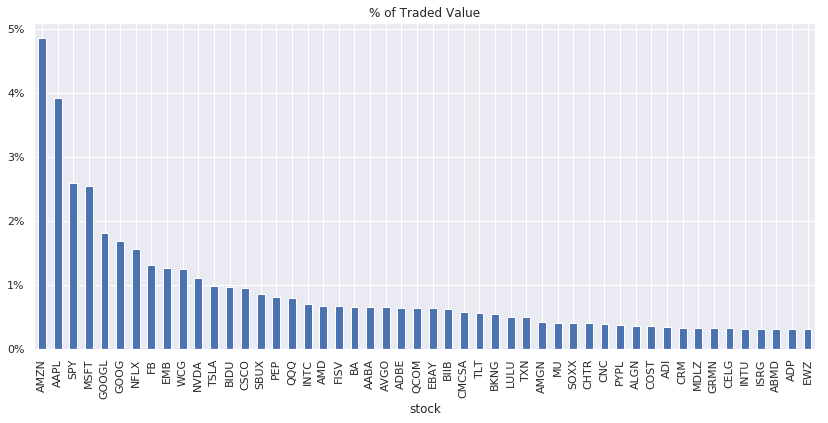

In [8]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)    
trades['value_share'] = trades.value.div(trades.value.sum())
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='b', title='% of Traded Value')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## AAPL Trade Summary

In [9]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

In [10]:
trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59233 entries, 2019-03-27 09:30:00.029662346 to 2019-03-27 15:59:59.940302031
Data columns (total 2 columns):
shares    59233 non-null int64
price     59233 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.4 MB


In [11]:
trades.head()

,shares,price
timestamp,,
2019-03-27 09:30:00.029662346,2,188.75
2019-03-27 09:30:00.029662346,600,188.75
2019-03-27 09:30:00.059062044,100,188.74
2019-03-27 09:30:00.059062044,100,188.74
2019-03-27 09:30:00.230977002,6,188.74


## Tick Bars

The trade data is indexed by nanoseconds and is very noisy. The bid-ask bounce, for instance, causes the price to oscillate between the bid and ask prices when trade initiation alternates between buy and sell market orders. To improve the noise-signal ratio and improve the statistical properties, we need to resample and regularize the tick data by aggregating the trading activity.

The idea behind tick bars is to sample observations every N transactions, aka “ticks”, instead of fixed time buckets. This allows us to capture more information at times when many trades take place, and vice-versa.

We typically collect the open (first), low, high, and closing (last) price for the aggregated period, alongside the volume-weighted average price (VWAP), the number of shares traded, and the timestamp associated with the data.

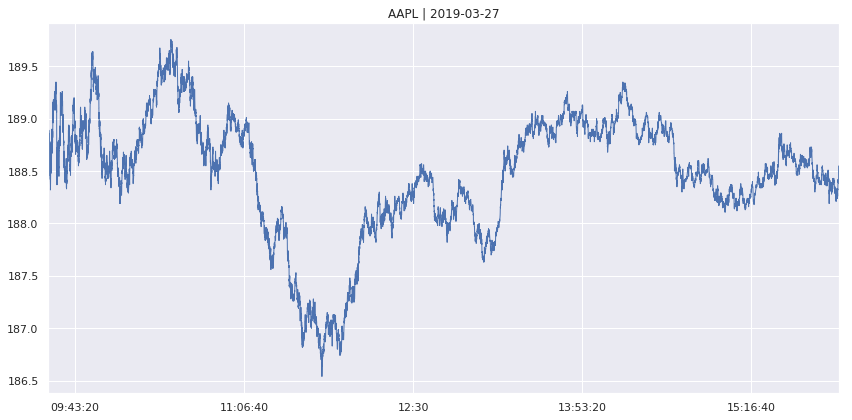

In [12]:
tick_bars = trades.copy()
tick_bars.index = tick_bars.index.time
tick_bars.price.plot(figsize=(12, 6), title='{} | {}'.format(stock, pd.to_datetime(date).date()), lw=1)
plt.xlabel('')
plt.tight_layout();

In [13]:
tick_bars.index = trades.index
tick_bars.head()

,shares,price
timestamp,,
2019-03-27 09:30:00.029662346,2,188.75
2019-03-27 09:30:00.029662346,600,188.75
2019-03-27 09:30:00.059062044,100,188.74
2019-03-27 09:30:00.059062044,100,188.74
2019-03-27 09:30:00.230977002,6,188.74


### Test for Normality of tick returns

In [14]:
normaltest(tick_bars.price.pct_change().dropna())

NormaltestResult(statistic=11417.148036373566, pvalue=0.0)

## Regularizing Tick Data

### Price-Volume Chart

We will use the `price_volume` function to compare the price-volume relation for various regularization methods.

In [73]:
#def price_volume(df, price='vwap', vol='vol', fmt='', suptitle=title):
def price_volume(df, price='vwap', vol='volume', fmt='', suptitle=title):

    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,8), gridspec_kw={'height_ratios': [2,1]})
    axes[0].plot(df.index, df[price], color='#00BCFF', linewidth=2.5)
    axes[1].bar(df.index, df[vol], width=1/(len(df.index)), color='r', alpha=.5)
    
    # formatting
    xfmt = mpl.dates.DateFormatter('%H:%M')
    axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
    axes[1].xaxis.set_major_formatter(xfmt)
    axes[1].get_xaxis().set_tick_params(which='major', pad=25)
    axes[0].set_title(f'{fmt} VWAP', fontsize=14)
    axes[1].set_title('Volume', fontsize=14)
    axes[0].margins(0.01)
    axes[1].margins(0.01)
    fig.autofmt_xdate()
    fig.suptitle(suptitle)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

### Time Bars

Time bars involve trade aggregation by period.

In [16]:
def get_bar_stats(agg_trades):
    vwap = agg_trades.apply(lambda x: np.average(x.price, weights=x.shares)).to_frame('vwap')
    ohlc = agg_trades.price.ohlc()
    vol = agg_trades.shares.sum().to_frame('vol')
    txn = agg_trades.shares.size().to_frame('txn')
    return pd.concat([ohlc, vwap, vol, txn], axis=1)    

We create time bars using the `.resample()` method with the desired period.

In [17]:
resampled = trades.resample('1Min')
time_bars = get_bar_stats(resampled)
normaltest(time_bars.vwap.pct_change().dropna())

NormaltestResult(statistic=24.646369641916355, pvalue=4.4474270458019155e-06)

In [18]:
time_bars.head()

,open,high,low,close,vwap,vol,txn
timestamp,,,,,,,
2019-03-27 09:30:00,188.75,188.89,188.30,188.68,188.65,73242,846
2019-03-27 09:31:00,188.64,188.90,188.32,188.72,188.64,38930,406
2019-03-27 09:32:00,188.74,189.18,188.72,189.18,189.03,48100,434
2019-03-27 09:33:00,189.16,189.35,189.08,189.20,189.22,35462,339
2019-03-27 09:34:00,189.20,189.20,188.37,188.77,188.70,75363,795


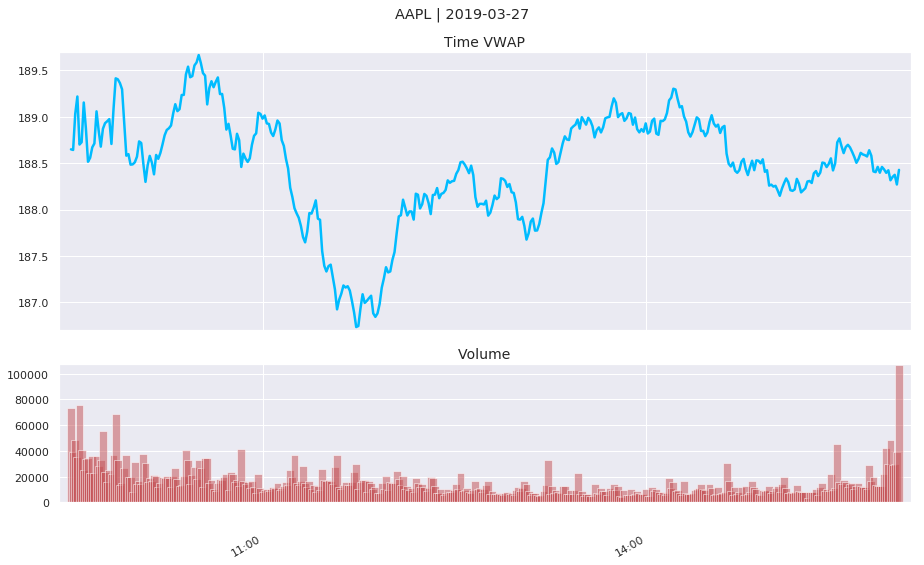

In [19]:
price_volume(time_bars, fmt='Time')

In [111]:
def compute_vwap(df):
    q = df['shares']
    p = df['price']
    vwap = np.sum(p * q) / np.sum(q)
    df['vwap'] = vwap
    return df

Time Bars

In [116]:
data_timeidx = trades.copy()
data_time_grp = data_timeidx.groupby(pd.Grouper(freq='5Min'))
num_time_bars = len(data_time_grp) # comes in handy later
data_time_vwap = data_time_grp.apply(compute_vwap)
data_time_vwap.head()

,shares,price,cumul_vol,dv,cumul_dol_vol,vwap
timestamp,,,,,,
2019-03-27 09:30:00.029662346,2,188.75,2,377.50,377.50,188.80
2019-03-27 09:30:00.029662346,600,188.75,602,113250.00,113627.50,188.80
2019-03-27 09:30:00.059062044,100,188.74,702,18874.00,132501.50,188.80
2019-03-27 09:30:00.059062044,100,188.74,802,18874.00,151375.50,188.80
2019-03-27 09:30:00.230977002,6,188.74,808,1132.44,152507.94,188.80


Tick Bars

In [118]:
total_ticks = len(tick_bars)
num_ticks_per_bar = total_ticks / num_time_bars
num_ticks_per_bar = round(num_ticks_per_bar, -3) # round to the nearest thousand

data_tick_grp = tick_bars.reset_index().assign(grpId=lambda row: row.index // num_ticks_per_bar)
data_tick_vwap =  data_tick_grp.groupby('grpId').apply(compute_vwap)
data_tick_vwap.set_index('timestamp', inplace=True)

time vs tick

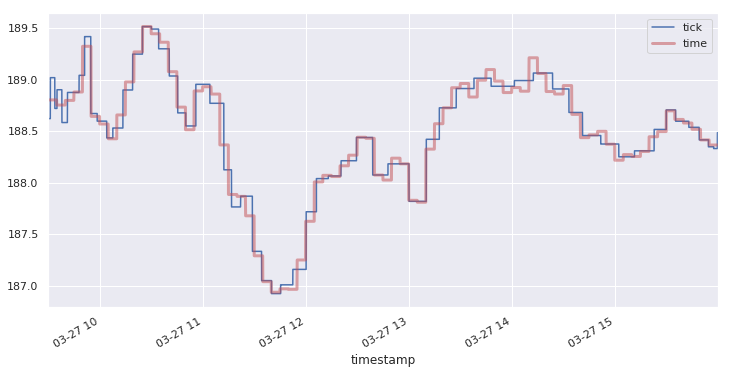

In [122]:
data_tick_vwap.vwap.plot(label='tick')
data_time_vwap.vwap.plot(label='time', color='r', lw=3, alpha=.5)
plt.legend();

In [80]:
num_time_bars = len(time_bars) # comes in handy later

total_ticks = len(tick_bars)
num_ticks_per_bar = total_ticks / num_time_bars
num_ticks_per_bar = round(num_ticks_per_bar, -3) # round to the nearest thousand

data_tick_grp = tick_bars.reset_index().assign(grpId=lambda row: row.index // num_ticks_per_bar)
data_tick_vwap =  data_tick_grp.groupby('grpId').apply(compute_vwap)
data_tick_vwap.head()

timestamp  shares  price  grpId   vwap
grpId                                                             
inf   1 2019-03-27 09:30:00.029662346     600 188.75    inf 188.75
      2 2019-03-27 09:30:00.059062044     100 188.74    inf 188.75
      3 2019-03-27 09:30:00.059062044     100 188.74    inf 188.75
      4 2019-03-27 09:30:00.230977002       6 188.74    inf 188.75
      5 2019-03-27 09:30:00.368157122     120 188.71    inf 188.74

### Bokeh Candlestick Chart

Alternative visualization using the the [bokeh](https://bokeh.pydata.org/en/latest/) library:

### Volume Bars

Time bars smooth some of the noise contained in the raw tick data but may fail to account for the fragmentation of orders. Execution-focused algorithmic trading may aim to match the volume weighted average price (VWAP) over a given period, and will divide a single order into multiple trades and place orders according to historical patterns. Time bars would treat the same order differently, even though no new information has arrived in the market.

We must aim for a bar representation in which each bar contains the same amount of information, however time-based bars will oversample slow periods and undersample high activity periods. To avoid this problem, the idea is to sample observations as a function of market activity.

Volume bars offer an alternative by aggregating trade data according to volume. We can accomplish this as follows:

In [20]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59233 entries, 2019-03-27 09:30:00.029662346 to 2019-03-27 15:59:59.940302031
Data columns (total 2 columns):
shares    59233 non-null int64
price     59233 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.4 MB


In [21]:
trades_per_min = trades.shares.sum()/(60*7.5) # min per trading day
trades['cumul_vol'] = trades.shares.cumsum()
print('Trades per min =', trades_per_min.round().astype(int))

Trades per min = 13089


In [22]:
df = trades.reset_index()
by_vol = df.groupby(df.cumul_vol.div(trades_per_min).round().astype(int))
vol_bars = pd.concat([by_vol.timestamp.last().to_frame('timestamp'), get_bar_stats(by_vol)], axis=1)
vol_bars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451 entries, 0 to 450
Data columns (total 8 columns):
timestamp    451 non-null datetime64[ns]
open         451 non-null float64
high         451 non-null float64
low          451 non-null float64
close        451 non-null float64
vwap         451 non-null float64
vol          451 non-null int64
txn          451 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 31.7 KB


In [23]:
vol_bars.head()

,timestamp,open,high,low,close,vwap,vol,txn
cumul_vol,,,,,,,,
0,2019-03-27 09:30:00.952259968,188.75,188.75,188.60,188.67,188.69,6526,71
1,2019-03-27 09:30:06.813279061,188.60,188.78,188.57,188.58,188.70,13022,141
2,2019-03-27 09:30:12.852328216,188.58,188.58,188.30,188.37,188.42,13088,161
3,2019-03-27 09:30:30.588840948,188.33,188.89,188.32,188.82,188.77,13143,173
4,2019-03-27 09:30:45.473718520,188.82,188.83,188.46,188.56,188.66,13051,148


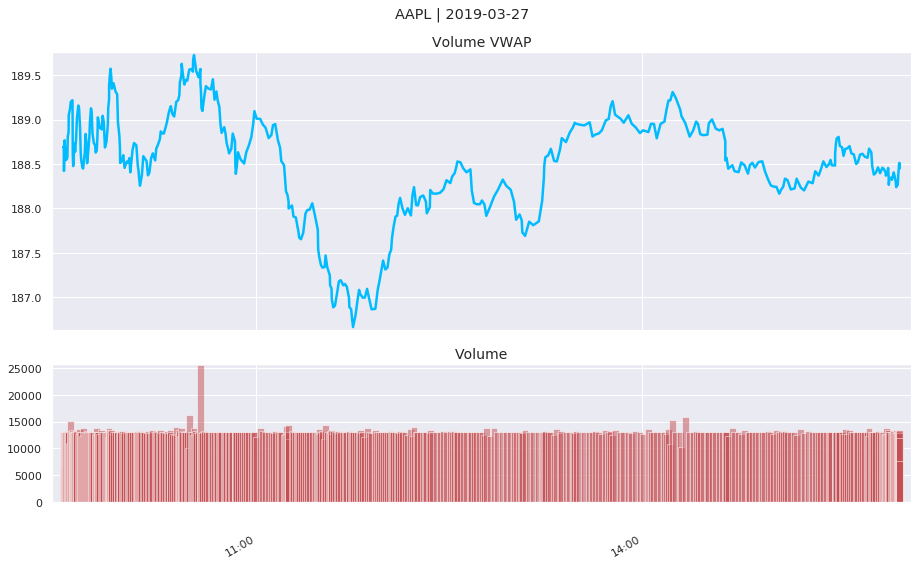

In [24]:
price_volume(vol_bars.set_index('timestamp'), fmt='Volume')

In [25]:
normaltest(vol_bars.vwap.dropna())

NormaltestResult(statistic=44.144066960487535, pvalue=2.5955993405406944e-10)

In [126]:
data_cm_vol = tick_bars.assign(cmVol=tick_bars['shares'].cumsum()) 
total_vol = data_cm_vol.cmVol.values[-1]
vol_per_bar = total_vol / num_time_bars
vol_per_bar = round(vol_per_bar, -2) # round to the nearest hundred

data_vol_grp = data_cm_vol.assign(grpId=lambda row: row.cmVol // vol_per_bar)
data_vol_vwap =  data_vol_grp.groupby('grpId').apply(compute_vwap)

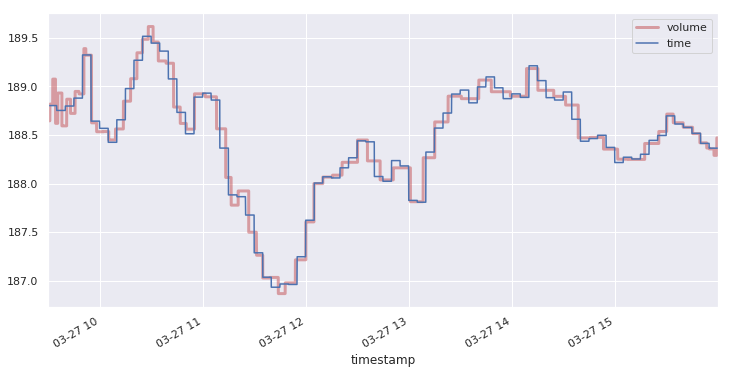

In [128]:
data_vol_vwap.vwap.plot(label='volume', color='r', lw=3, alpha=.5)
data_time_vwap.vwap.plot(label='time')
plt.legend();

### Dollar bars
When asset prices change significantly or after stock splits, the value of a given amount of
shares changes. Volume bars do not correctly reflect this and can hamper the comparison of
trading behavior for different periods that reflect such changes. In these cases, the volume
bar method should be adjusted to utilize the product of shares and price to produce dollar
bars.

In [26]:
trades['dv'] = trades.shares * trades.price
trades_per_min = trades.dv.sum()/(60*7.5) # min per trading day
trades['cumul_dol_vol'] = trades.dv.cumsum()

In [27]:
df = trades.reset_index()
by_dol_vol = df.groupby(df.cumul_dol_vol.div(trades_per_min).round().astype(int))
dol_vol_bars = pd.concat([by_dol_vol.timestamp.last().to_frame('timestamp'), get_bar_stats(by_dol_vol)], axis=1)
dol_vol_bars.head()

,timestamp,open,high,low,close,vwap,vol,txn
cumul_dol_vol,,,,,,,,
0,2019-03-27 09:30:00.952259968,188.75,188.75,188.60,188.67,188.69,6526,71
1,2019-03-27 09:30:06.813279061,188.60,188.78,188.57,188.58,188.70,13022,141
2,2019-03-27 09:30:12.852328216,188.58,188.58,188.30,188.37,188.42,13088,161
3,2019-03-27 09:30:30.588816388,188.33,188.89,188.32,188.82,188.77,13079,172
4,2019-03-27 09:30:45.473718520,188.82,188.83,188.46,188.56,188.66,13115,149


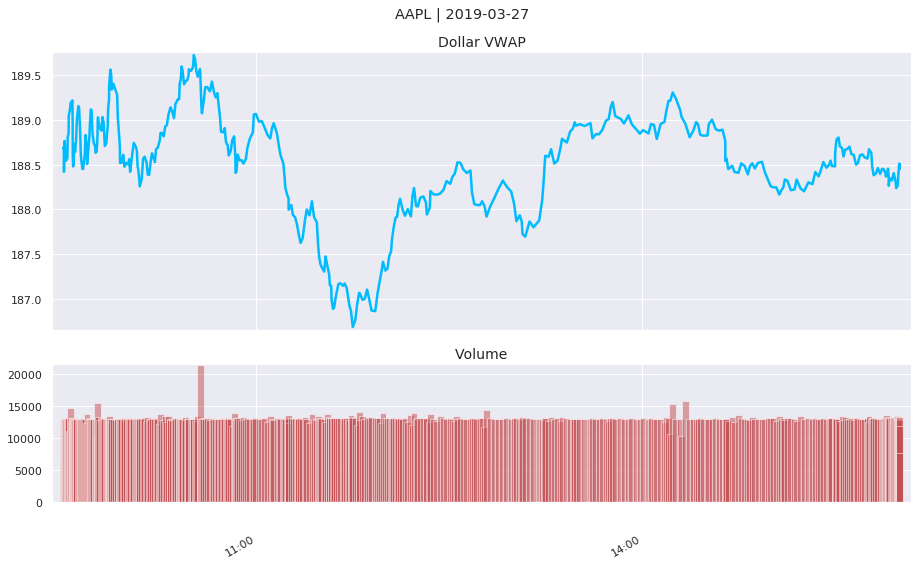

In [28]:
price_volume(dol_vol_bars.set_index('timestamp'), fmt='Dollar')

In [129]:
tick_bars['dv'] = tick_bars['shares'] * tick_bars['price']
data_cm_dv = tick_bars.assign(cmdv=tick_bars['dv'].cumsum()) 
total_dv = data_cm_dv.cmdv.values[-1]
dv_per_bar = total_dv / num_time_bars
dv_per_bar = round(dv_per_bar, -2) # round to the nearest hundred

data_dv_grp = data_cm_dv.assign(grpId=lambda row: row.cmdv // dv_per_bar)
data_dv_vwap = data_dv_grp.groupby('grpId').apply(compute_vwap)

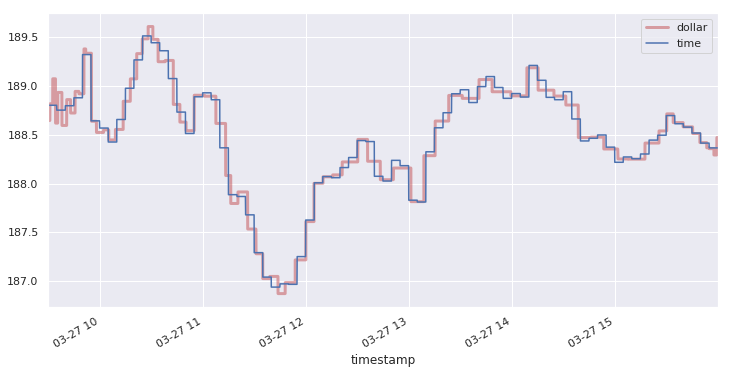

In [130]:
data_dv_vwap.vwap.plot(label='dollar', color='r', lw=3, alpha=.5)
data_time_vwap.vwap.plot(label='time')
plt.legend();

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
normaltest(dol_vol_bars.vwap.dropna())

NormaltestResult(statistic=44.297816951471766, pvalue=2.4035395279319906e-10)

In [31]:
new_data = trades[['price','shares']]
new_data['date'] = trades.index
cols = ['price', 'volume','date']
new_data.columns = cols
new_data = new_data[['date', 'price', 'volume']]
new_data = new_data.reset_index(drop=True)

In [134]:
new_data.head()

,date,price,volume
0,2019-03-27 09:30:00.029662346,188.75,2
1,2019-03-27 09:30:00.029662346,188.75,600
2,2019-03-27 09:30:00.059062044,188.74,100
3,2019-03-27 09:30:00.059062044,188.74,100
4,2019-03-27 09:30:00.230977002,188.74,6


In [33]:
new_data.to_csv('new_data.csv', index=False)

There are many ways to choose M, or the threshold value for sampling prices. One way is based on ratios of total dollar value/volume traded vs number of ticks. The rest of the notebook uses an arbitrary but sensible M value. I leave it as an exercise for the reader to see how the results change based on different values of M.

In [132]:
df = new_data.copy()
df.dv = df.price * df.volume

n_ticks = df.shape[0]
volume_ratio = (df.volume.sum()/n_ticks).round()
dollar_ratio = (df.dv.sum()/n_ticks).round()

print(f'num ticks: {n_ticks:,}')
print(f'volume ratio: {volume_ratio}')
print(f'dollar ratio: {dollar_ratio}')

num ticks: 59,233
volume ratio: 99.0
dollar ratio: 18744.0


In [159]:
import mlfinlab as ml

print('Creating Dollar Bars')
dollar = ml.data_structures.get_dollar_bars('new_data.csv', threshold=1_688_000, batch_size=1000000, verbose=True)
print('')

print('Creating Volume Bars')
volume = ml.data_structures.get_volume_bars('new_data.csv', threshold=9000, batch_size=1000000, verbose=True)

print('')

print('Creating Tick Bars')
tick = ml.data_structures.get_tick_bars('new_data.csv', threshold=92, batch_size=1000000, verbose=True)

Creating Dollar Bars
Reading data in batches:
Batch number: 0
Returning bars 


Creating Volume Bars
Reading data in batches:
Batch number: 0
Returning bars 


Creating Tick Bars
Reading data in batches:
Batch number: 0
Returning bars 



In [160]:
print('Dollar:', dollar.shape)
print('Tick:', tick.shape)
print('Volume:', volume.shape)
print('Time:', time_bars.shape)

Dollar: (647, 6)
Tick: (643, 6)
Volume: (643, 6)
Time: (390, 7)


In [158]:
dollar.head()

,date_time,open,high,low,close,volume
0,2019-03-27 09:30:00.965298363,188.75,188.75,188.60,188.71,9051
1,2019-03-27 09:30:05.623886640,188.71,188.78,188.58,188.63,8979
2,2019-03-27 09:30:08.119528980,188.63,188.65,188.31,188.41,8970
3,2019-03-27 09:30:20.943002881,188.41,188.85,188.30,188.82,8959
4,2019-03-27 09:30:29.037917057,188.82,188.89,188.75,188.77,9038


In [138]:
dollar = dollar.set_index('date_time')
dollar.index = pd.DatetimeIndex(dollar.index)

volume = volume.set_index('date_time')
volume.index = pd.DatetimeIndex(volume.index)

tick = tick.set_index('date_time')
tick.index = pd.DatetimeIndex(tick.index)

# Downsample to weekly periods
tick_count = tick['close'].resample('15Min', label='right').count()
volume_count = volume['close'].resample('15Min', label='right').count()
dollar_count = dollar['close'].resample('15Min', label='right').count()
time_count = time_bars['close'].resample('15Min', label='right').count()

count_df = pd.concat([time_count, tick_count, volume_count, dollar_count], axis=1)
count_df.columns = ['time', 'tick', 'volume', 'dollar']

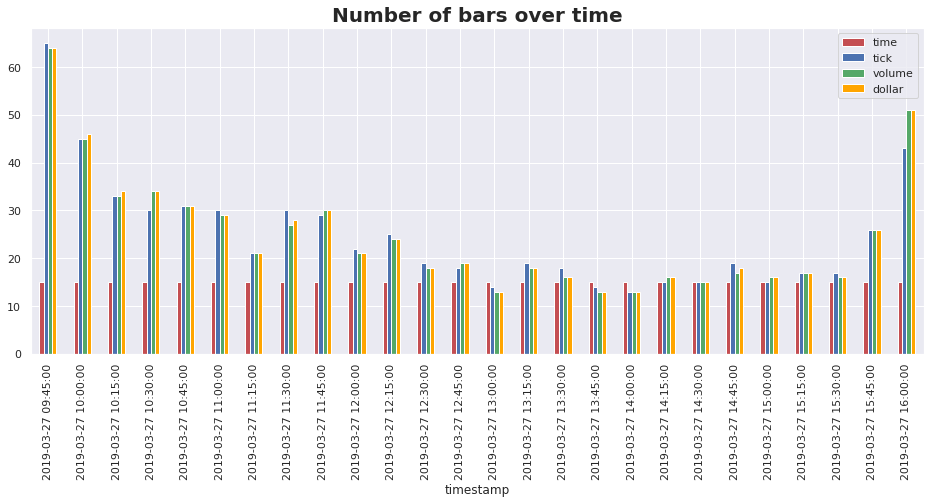

In [139]:
# Plot Number of Bars Over Time
count_df.loc[:, ['time', 'tick', 'volume', 'dollar']].plot(kind='bar', figsize=[16, 6], 
                                                 color=('r', 'b', 'g', 'orange'))

plt.title('Number of bars over time', loc='center', fontsize=20, fontweight="bold")

plt.show()

In [140]:
# Calculate log returns
tick_returns = np.log(tick.close).diff().dropna()
volume_returns = np.log(volume.close).diff().dropna()
dollar_returns = np.log(dollar.close).diff().dropna()
time_returns = np.log(time_bars.close).diff().dropna()

In [141]:
from scipy import stats

print('Jarque_bera test statistics:')
print('Time:', '\t', int(stats.jarque_bera(time_returns)[0]))
print('Tick:', '\t', int(stats.jarque_bera(tick_returns)[0]))
print('Volume: ', int(stats.jarque_bera(volume_returns)[0]))
print('Dollar: ', int(stats.jarque_bera(dollar_returns)[0]))

Jarque_bera test statistics:
Time: 	 37
Tick: 	 11
Volume:  7
Dollar:  4


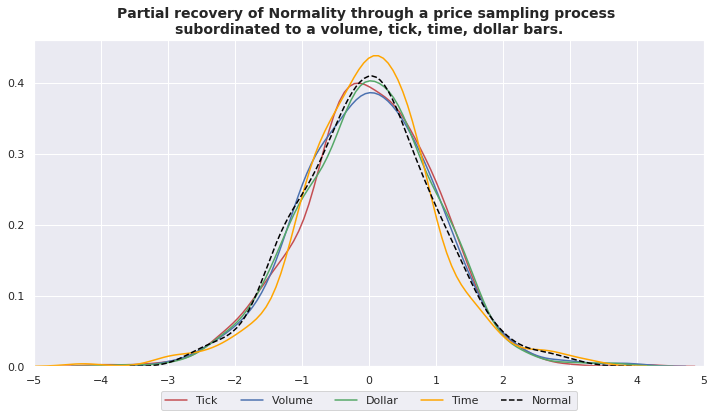

In [142]:
# Calculate the differences
time_diff = time_returns
tick_diff = tick_returns
volume_diff = volume_returns
dollar_diff = dollar_returns

# Standardize the data
time_standard = (time_diff - time_diff.mean()) / time_diff.std()
tick_standard = (tick_diff - tick_diff.mean()) / tick_diff.std()
volume_standard = (volume_diff - volume_diff.mean()) / volume_diff.std()
dollar_standard = (dollar_diff - dollar_diff.mean()) / dollar_diff.std()

# Plot the Distributions
plt.figure(figsize=(12,6))
sns.kdeplot(tick_standard, label="Tick", color='r')
sns.kdeplot(volume_standard, label="Volume", color='b')
sns.kdeplot(dollar_standard, label="Dollar", color='g')
sns.kdeplot(time_standard, label="Time", color='orange')
sns.kdeplot(np.random.normal(size=len(volume_returns)), label="Normal", color='black', linestyle="--")

plt.xticks(range(-5, 6))
plt.legend(loc=8, ncol=5, bbox_to_anchor=(.5, -0.15))
plt.title('Partial recovery of Normality through a price sampling process \nsubordinated to a volume, tick, time, dollar bars.',
          loc='center', fontsize=14, fontweight="bold")
plt.xlim(-5, 5)
plt.show()

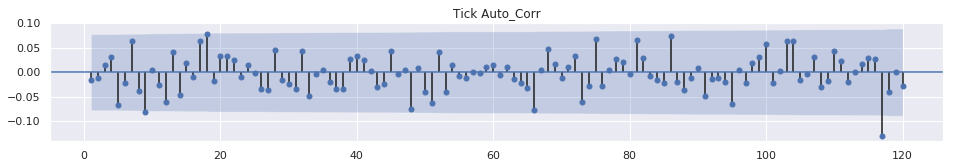


Tick: NormaltestResult(statistic=9.523245157638087, pvalue=0.008551722290627001)



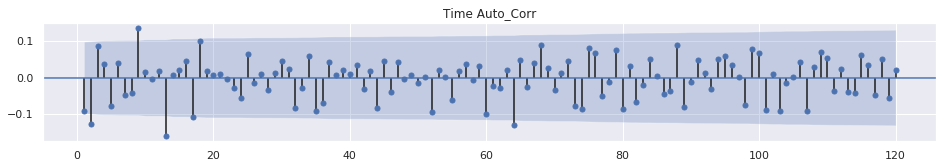


Time: NormaltestResult(statistic=16.260570258426974, pvalue=0.0002944842227792495)



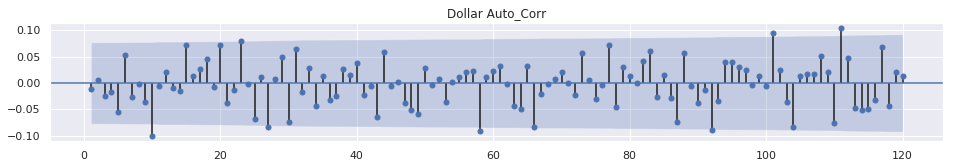


Dollar: NormaltestResult(statistic=3.5738445274807864, pvalue=0.1674748206088165)



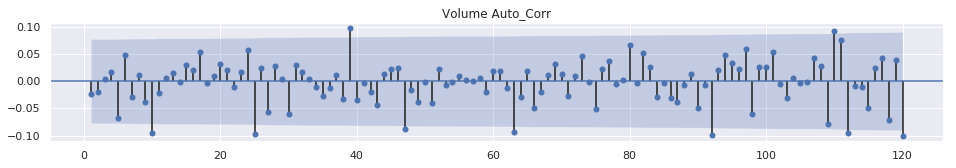


Volume: NormaltestResult(statistic=5.997955813001549, pvalue=0.04983798142130641)


In [143]:
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(411)
fig = sm.graphics.tsa.plot_acf(tick_returns, lags=120, alpha=0.05, unbiased=True, fft=True, zero=False, title='Tick Auto_Corr', ax=ax1)
plt.show()
print('')
print('Tick:',normaltest(tick_returns.dropna()))
print('')

fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(412)
fig = sm.graphics.tsa.plot_acf(time_returns, lags=120, alpha=0.05, unbiased=True, fft=True, zero=False, title='Time Auto_Corr', ax=ax1)
plt.show()
print('')
print('Time:',normaltest(time_returns.dropna()))
print('')

fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(413)
fig = sm.graphics.tsa.plot_acf(dollar_returns, lags=120, alpha=0.05, unbiased=True, fft=True, zero=False, title='Dollar Auto_Corr', ax=ax1)
plt.show()
print('')
print('Dollar:',normaltest(dollar_returns.dropna()))
print('')

fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(414)
fig = sm.graphics.tsa.plot_acf(volume_returns, lags=120, alpha=0.05, unbiased=True, fft=True, zero=False, title='Volume Auto_Corr', ax=ax1)
plt.show()
print('')
print('Volume:',normaltest(volume_returns.dropna()))

In [144]:
trades.head()

,shares,price,cumul_vol,dv,cumul_dol_vol
timestamp,,,,,
2019-03-27 09:30:00.029662346,2,188.75,2,377.50,377.50
2019-03-27 09:30:00.029662346,600,188.75,602,113250.00,113627.50
2019-03-27 09:30:00.059062044,100,188.74,702,18874.00,132501.50
2019-03-27 09:30:00.059062044,100,188.74,802,18874.00,151375.50
2019-03-27 09:30:00.230977002,6,188.74,808,1132.44,152507.94


In [145]:
from mlfinlab.data_structures import imbalance_data_structures

print('Creating Dollar Imbalance Bars')
dol_imb = imbalance_data_structures.get_dollar_imbalance_bars('new_data.csv', num_prev_bars=3, 
                                                              exp_num_ticks_init=0, verbose=True)

dol_imb['dv'] = dol_imb.volume * dol_imb.close

dol_imb.info()

Creating Dollar Imbalance Bars
Reading data in batches:
Batch number: 0
Returning bars 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647 entries, 0 to 646
Data columns (total 7 columns):
date_time    647 non-null object
open         647 non-null float64
high         647 non-null float64
low          647 non-null float64
close        647 non-null float64
volume       647 non-null int64
dv           647 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 35.5+ KB


In [146]:
dol_imb.head()

,date_time,open,high,low,close,volume,dv
0,2019-03-27 09:30:00.059062044,188.75,188.75,188.74,188.74,702,132495.48
1,2019-03-27 09:30:00.368157122,188.74,188.74,188.71,188.71,226,42648.46
2,2019-03-27 09:30:00.433675317,188.71,188.71,188.71,188.71,900,169839.00
3,2019-03-27 09:30:00.650151592,188.71,188.72,188.70,188.70,1024,193228.80
4,2019-03-27 09:30:00.952333436,188.70,188.71,188.60,188.60,4174,787216.40


In [147]:
tidx = dol_imb.close * dol_imb.dv
tidx.index = dol_imb.date_time
tidx[:5]

date_time
2019-03-27 09:30:00.059062044    25007196.90
2019-03-27 09:30:00.368157122     8048190.89
2019-03-27 09:30:00.433675317    32050317.69
2019-03-27 09:30:00.650151592    36462274.56
2019-03-27 09:30:00.952333436   148469013.04
dtype: float64

In [148]:
#wndo = tidx.shape[0]//1000
wndo = 1
print(f'window size: {wndo:,.2f}')

## Expected value of bs approximated by ewm
E_bs = tidx.ewm(wndo).mean() # expected `bs`

## what is E_T??? 
## in this implementation E_T is ewm of index values
E_T = pd.Series(range(tidx.shape[0]), index=tidx.index).ewm(wndo).mean()

df0 =(pd.DataFrame().assign(bs=tidx)
      .assign(E_T=E_T).assign(E_bs=E_bs)
      .assign(absMul=lambda df: df.E_T*np.abs(df.E_bs))
      .assign(absTheta=tidx.cumsum().abs()))

print(df0.head())

window size: 1.00
                                        bs  E_T        E_bs       absMul  \
date_time                                                                  
2019-03-27 09:30:00.059062044  25007196.90 0.00 25007196.90         0.00   
2019-03-27 09:30:00.368157122   8048190.89 0.67 13701192.89   9134128.59   
2019-03-27 09:30:00.433675317  32050317.69 1.43 24186407.06  34552010.09   
2019-03-27 09:30:00.650151592  36462274.56 2.27 30733536.39  69662682.49   
2019-03-27 09:30:00.952333436 148469013.04 3.16 91500234.02 289258804.31   

                                  absTheta  
date_time                                   
2019-03-27 09:30:00.059062044  25007196.90  
2019-03-27 09:30:00.368157122  33055387.78  
2019-03-27 09:30:00.433675317  65105705.47  
2019-03-27 09:30:00.650151592 101567980.03  
2019-03-27 09:30:00.952333436 250036993.07  


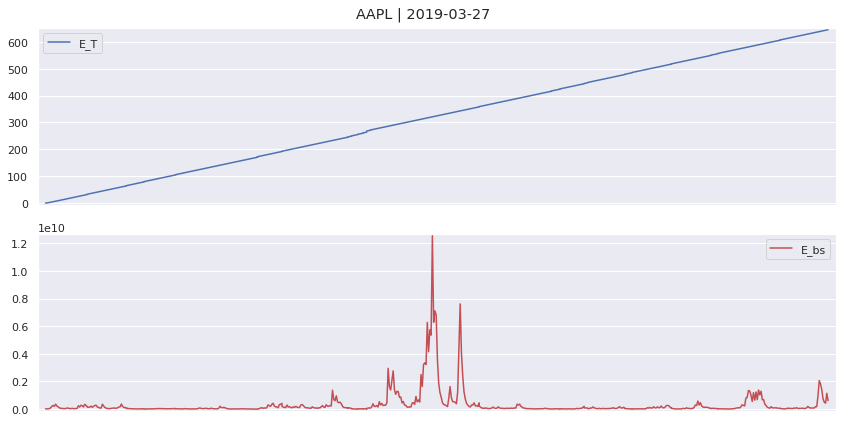

In [149]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,6))
axes[0].plot(df0.index, df0['E_T'])
axes[1].plot(df0.index, df0['E_bs'], color='r')
    
# formatting
xfmt = mpl.dates.DateFormatter('%H:%M')
axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
axes[1].xaxis.set_major_formatter(xfmt)
axes[1].get_xaxis().set_tick_params(which='major', pad=25)
axes[0].margins(0.01)
axes[1].margins(0.01)
axes[0].legend()
axes[1].legend()
fig.autofmt_xdate()
fig.suptitle(title)
fig.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

In [150]:
print(df0.describe()/1000)

               bs  E_T        E_bs        absMul     absTheta
count        0.65 0.65        0.65          0.65         0.65
mean    323205.47 0.32   322304.72  112067933.85  96432651.48
std    1230393.36 0.19   957619.69  325303401.46  79336363.26
min        214.62 0.00     4050.69          0.00     25007.20
25%      18221.97 0.16    28033.49    5472776.42  11716875.05
50%      51448.00 0.32    72047.17   20509694.64 117006103.06
75%     159473.66 0.48   203840.59   59550200.60 171749635.35
max   19742254.34 0.65 12547298.26 4027682741.76 209113938.84


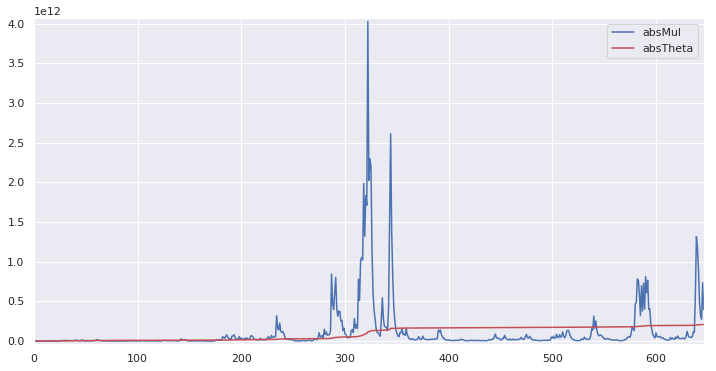

In [151]:
(df0[['absMul','absTheta']].reset_index(drop=True).plot(figsize=(12,6), color=['b','r']))
plt.margins(0.01)
plt.show()

In [152]:
dol_imb_returns = np.log(dol_imb.close).diff().dropna()

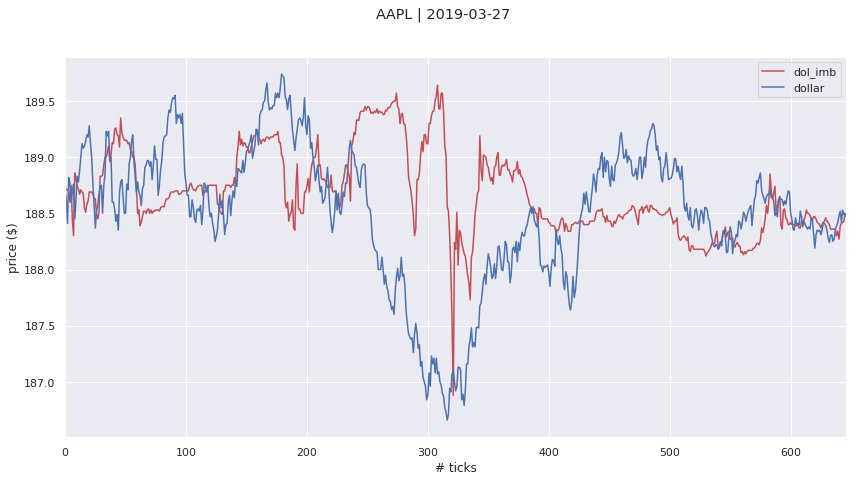

Jarque_bera test statistics:
Dollar:  4
Dollar Imbalance:  47349



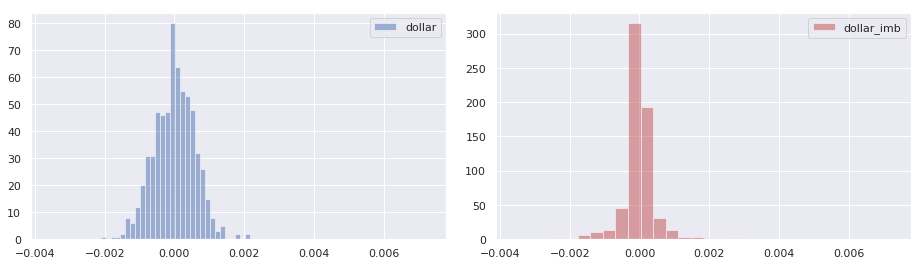

Shapiro test statistics:
Dollar:  0.9961149096488953
Dollar Imbalance:  0.6841970086097717


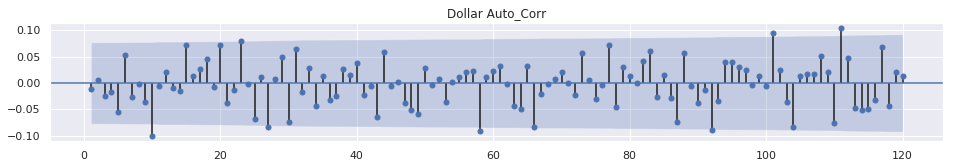


Dollar: NormaltestResult(statistic=3.5738445274807864, pvalue=0.1674748206088165)



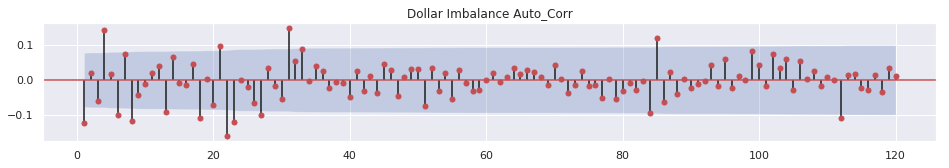


Dollar Imbalance: NormaltestResult(statistic=505.34926424121, pvalue=1.8399310695903745e-110)



In [153]:
dol_imb.close.plot(figsize=(12,6), color='r')
dollar.reset_index(drop=False).close.plot(figsize=(14,7))
plt.legend(("dol_imb", "dollar"))
plt.ylabel('price ($)')
plt.xlabel('# ticks')
plt.suptitle(title)
plt.show()

print('Jarque_bera test statistics:')
print('Dollar: ', int(stats.jarque_bera(dollar_returns)[0]))
print('Dollar Imbalance: ', int(stats.jarque_bera(dol_imb_returns)[0]))
print('')

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(13,4))
axes[0].hist(dollar_returns, color='b', bins=30, alpha=0.5, label='dollar')
axes[1].hist(dol_imb_returns, color='r', bins=30, alpha=0.5, label='dollar_imb')
axes[0].legend()
axes[1].legend()
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

print('Shapiro test statistics:')
print('Dollar: ', stats.shapiro(dollar_returns)[0])
print('Dollar Imbalance: ', stats.shapiro(dol_imb_returns)[0])

fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(411)
fig = sm.graphics.tsa.plot_acf(dollar_returns, lags=120, alpha=0.05, unbiased=True, fft=True, zero=False, 
                               title='Dollar Auto_Corr', ax=ax1)
plt.show()
print('')
print('Dollar:',normaltest(dollar_returns.dropna()))
print('')

fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(412)
fig = sm.graphics.tsa.plot_acf(dol_imb_returns, lags=120, alpha=0.05, unbiased=True, fft=True, zero=False, 
                               title='Dollar Imbalance Auto_Corr', ax=ax1, color='r')
plt.show()
print('')
print('Dollar Imbalance:',normaltest(dol_imb_returns.dropna()))
print('')